In [1]:
# Import packages

# Keras framework 
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

# Scikit-learn
from sklearn.metrics import mean_squared_error

# data analysis packages
import numpy as np

# plotting tools
from matplotlib import rcParams  # next 3 lines set font family for plotting
rcParams['font.family'] = ['serif']
rcParams['font.sans-serif'] = ['Optima']
rcParams['font.serif'] = ['Didot']
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

# misc. packages
import os  # file navigation
import h5py

Using TensorFlow backend.


In [2]:
# SETTINGS FOR REPRODUCIBLE RESULTS DURING DEVELOPMENT

import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

#import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
# read in preprocessed data

with h5py.File('pulse2D_MLP_X.hdf5','r') as f:
    X_train = np.array(f['X_train'])
    X_test = np.array(f['X_test'])

with h5py.File('pulse2D_MLP_Y.hdf5','r') as f:
    Y_train = np.array(f['Y_train'])
    Y_test = np.array(f['Y_test'])

In [4]:
# misc parameters
Ndomain_nodes = 20  # number of 'timesteps', in this case is equal to the number of domain nodes
XNfeatures = X_train.shape[1]  # static features
YNfeatures = Ndomain_nodes  # only one prediction of interest....(Cmax)

# HYPERPARAMETERS
epochs = 1000  # the number of forward/backward passes to train each model
batch_size = 5000  # number of samples to be trained at a time for batch processing
do = 0.1  # dropout rate - fraction of samples that do not receive updates per epoch, helps with regularization
Nnodes = 5  # nodes per hidden layer
es_thresh = 0.001  # minimum improvement needed to avoid early stopping
lr_decay = 0.5  # factor by which to reduce the learning rate if it has not improved w/in patience
cb_patience = 15  # number of epochs to wait to activate callback functions

In [5]:
# build MLP model

# create input layer..........
main_input = Input(shape=(XNfeatures), # number features in the input dataset
                   dtype='float',  # number type - floating point, usually double precision
                   batch_shape=(batch_size,XNfeatures),  # shape of each batch size
                   name='main_input'  # name of input layer
                   )

#create hidden layers..........
hidden_layer1 = Dense(Nnodes, # number nodes in hidden layer
                      activation='tanh',  # activation function to apply to output of hidden layer
                      name='hidden_layer1'  # name of hidden layer
                      )(main_input)
Dropout(do)(hidden_layer1)  # add dropout to hidden layer
hidden_layer1 = BatchNormalization()(hidden_layer1)  # add batch normalization
hidden_layer2 = Dense(Nnodes, 
                      activation='tanh', 
                      name='hidden_layer2'
                      )(hidden_layer1)
Dropout(do)(hidden_layer2)

# create output layer
main_output = Dense(YNfeatures, # number of features in output array
                    name='main_output'  # name of output layer
                    )(hidden_layer2)  # default activation is linear

# initialize the model, feed layers into model for training
model = Model(inputs=[main_input], 
              outputs=[main_output]
              )

# compile the model with desired configuration
model.compile(loss='mean_squared_error',  # loss function to calculate at the end of each epoch
              optimizer='adam',  # optimization method to minimize cost function
              )

# one of several callbacks available in Keras, csv_logger saves metrics for every epoch to a csv file
csv_logger = CSVLogger('trainingMLP_' + str(epochs) + '.log')

# if the model isn't improving, stop before the desired number epochs has been reached
early_stop = EarlyStopping(monitor='val_loss', # quantity to monitor
                           min_delta=es_thresh,  # min change to qualify as an improvement
                           patience=cb_patience + 200, # stop after #epochs with no improvement
                           verbose=1)  # print messages

# if the loss isn't decreasing, reduce the learning rate aid in optimization
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=lr_decay,  # reduction factor (new_lr = lr * factor)
                              patience=cb_patience, # stop after #epochs with no improvement
                              verbose=1)

# train the model, and store training information in the history object
history = model.fit([X_train],[Y_train],  # pass in training datasets
                    validation_data=(X_test, Y_test),  # pass in test data - not used in training
                    # set hyperparameters and callbacks
                    epochs=epochs,
                    batch_size = batch_size,
#                    callbacks=[csv_logger,reduce_lr]
                    callbacks=[reduce_lr,early_stop,csv_logger]
                    )

histdict = history.history  # save the model output as a dictionary
model.summary()  # print out a summary of layers/parameters
config = model.get_config()  # detailed information about the configuration of each layer

Train on 90000 samples, validate on 10000 samples
Epoch 1/1000
90000/90000 [==============================] - 1s 7us/step - loss: 2.1564e-04 - val_loss: 0.0026
Epoch 2/1000
90000/90000 [==============================] - 0s 3us/step - loss: 1.0545e-04 - val_loss: 0.0165
Epoch 3/1000
90000/90000 [==============================] - 0s 3us/step - loss: 8.4252e-05 - val_loss: 0.0401
Epoch 4/1000
90000/90000 [==============================] - 0s 2us/step - loss: 7.1916e-05 - val_loss: 0.0603
Epoch 5/1000
90000/90000 [==============================] - 0s 3us/step - loss: 6.4008e-05 - val_loss: 0.0724
Epoch 6/1000
90000/90000 [==============================] - 0s 2us/step - loss: 5.8346e-05 - val_loss: 0.0781
Epoch 7/1000
90000/90000 [==============================] - 0s 3us/step - loss: 5.4169e-05 - val_loss: 0.0800
Epoch 8/1000
90000/90000 [==============================] - 0s 3us/step - loss: 5.0985e-05 - val_loss: 0.0796
Epoch 9/1000
90000/90000 [==============================] - 0s 3us/ste

90000/90000 [==============================] - 0s 2us/step - loss: 3.7044e-05 - val_loss: 4.8456e-04
Epoch 72/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.7032e-05 - val_loss: 4.7638e-04
Epoch 73/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.7021e-05 - val_loss: 4.6459e-04
Epoch 74/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.7009e-05 - val_loss: 4.5364e-04
Epoch 75/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.6999e-05 - val_loss: 4.4472e-04
Epoch 76/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.6988e-05 - val_loss: 4.3829e-04
Epoch 77/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.6977e-05 - val_loss: 4.2714e-04
Epoch 78/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.6967e-05 - val_loss: 4.1961e-04
Epoch 79/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.6956e-05 - 

90000/90000 [==============================] - 0s 2us/step - loss: 3.6609e-05 - val_loss: 4.7755e-05
Epoch 141/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6608e-05 - val_loss: 4.6588e-05
Epoch 142/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6607e-05 - val_loss: 4.5659e-05
Epoch 143/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6605e-05 - val_loss: 4.4823e-05
Epoch 144/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6605e-05 - val_loss: 4.4151e-05
Epoch 145/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6603e-05 - val_loss: 4.3673e-05
Epoch 146/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6602e-05 - val_loss: 4.3142e-05
Epoch 147/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6601e-05 - val_loss: 4.2872e-05
Epoch 148/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.659

Epoch 208/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.6579e-05 - val_loss: 3.5966e-05
Epoch 209/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6579e-05 - val_loss: 3.5965e-05
Epoch 210/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6579e-05 - val_loss: 3.5965e-05

Epoch 00210: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 211/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6578e-05 - val_loss: 3.5958e-05
Epoch 212/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6578e-05 - val_loss: 3.5954e-05
Epoch 213/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6578e-05 - val_loss: 3.5950e-05
Epoch 214/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6578e-05 - val_loss: 3.5947e-05
Epoch 215/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6578e-05 - val_loss: 3.

90000/90000 [==============================] - 0s 2us/step - loss: 3.6577e-05 - val_loss: 3.5927e-05
Epoch 276/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.6577e-05 - val_loss: 3.5927e-05
Epoch 277/1000
90000/90000 [==============================] - 0s 1us/step - loss: 3.6577e-05 - val_loss: 3.5927e-05
Epoch 278/1000
90000/90000 [==============================] - 0s 1us/step - loss: 3.6577e-05 - val_loss: 3.5927e-05
Epoch 279/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6577e-05 - val_loss: 3.5927e-05
Epoch 280/1000
90000/90000 [==============================] - 0s 3us/step - loss: 3.6577e-05 - val_loss: 3.5927e-05
Epoch 281/1000
90000/90000 [==============================] - 0s 2us/step - loss: 3.6577e-05 - val_loss: 3.5927e-05
Epoch 282/1000
90000/90000 [==============================] - 0s 1us/step - loss: 3.6577e-05 - val_loss: 3.5927e-05
Epoch 283/1000
90000/90000 [==============================] - 0s 1us/step - loss: 3.657

In [6]:
# evaluate the trained model on the test data set 

# test how well the model can predict Cmax given only the reserved input test dataset 
predict = model.predict([X_test],batch_size=batch_size)
Y_rmse = np.sqrt(mean_squared_error(predict,Y_test))
print('Y_rmse:   ',Y_rmse)
model.save('MLP_' + str(epochs) + 'epochs.h5')


Y_rmse:    0.005993873691265955


C:\Users\kathe\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


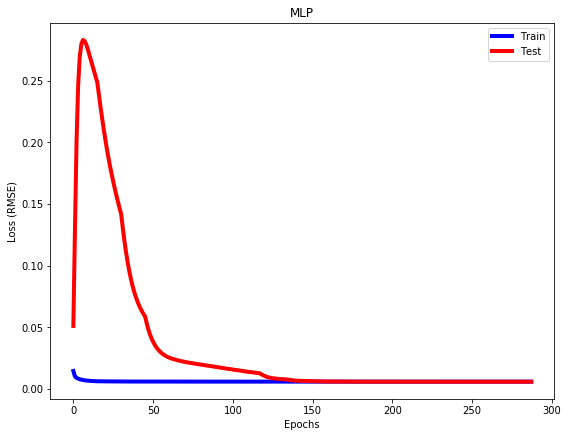

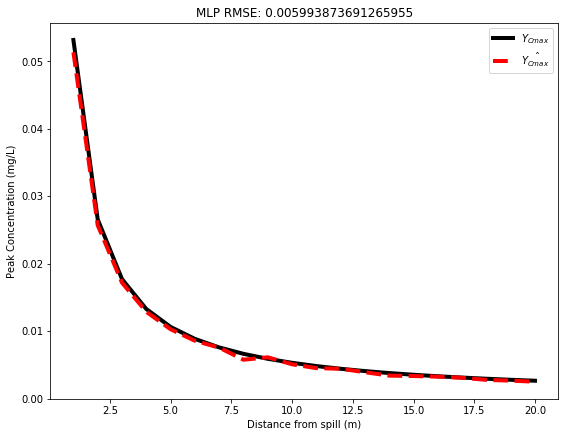

In [7]:
# plot MLP output

loss_train = histdict['loss']
loss_test = histdict['val_loss']
xplot = list(range(len(loss_train)))

fig = plt.figure(num=1, figsize=(8,6))
ax = fig.add_subplot(111)
train = ax.plot(xplot,np.sqrt(loss_train),'b-', label='Train', linewidth=4)
test = ax.plot(xplot,np.sqrt(loss_test),'r-',label='Test',linewidth=4)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (RMSE)')
curves = train + test
labels = [c.get_label() for c in curves]
ax.legend(curves, labels, loc=0)
plt.tight_layout()
plt.title('MLP')
plt.savefig('MLPout' + str(epochs) + 'epochs.png')
plt.show()

xplot2 = list(range(1,21))
fig = plt.figure(num=2, figsize=(8,6))
ax = fig.add_subplot(111)
y_test = ax.plot(xplot2,Y_test[0],'k-', label=r'$Y_{Cmax}$', linewidth=4)
y_predict = ax.plot(xplot2,predict[0],'r--',label=r'$\hat{Y_{Cmax}}$',linewidth=4)
ax.set_xlabel('Distance from spill (m)')
ax.set_ylabel('Peak Concentration (mg/L)')
curves = y_test + y_predict
labels = [c.get_label() for c in curves]
ax.legend(curves, labels, loc=0)
plt.tight_layout()
plt.title('MLP RMSE: ' + str(Y_rmse))
plt.savefig('MLPpredict' + str(epochs) + 'epochs.png')
plt.show()
